In [1]:
import smogn
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import copy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestRegressor
import subprocess
from sklearn.model_selection import RandomizedSearchCV
import sys
import math
import scipy.spatial.distance
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.tree import DecisionTreeRegressor
import os
import shutil
import glob
import shap
from sklearn.model_selection import train_test_split

cmap='viridis'
sys.path.insert(1, '../')
from LibHelperFuncs import *

from iterative_spectral_method.src import *
from iterative_spectral_method.sdr import *

rstate = 0
np.random.seed(rstate)
njob = -1
global_trees = 100

np.random.seed(rstate)

from sklearn.neural_network import MLPRegressor

C:\Users\tommy\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\tommy\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\tommy\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\tommy\AppData\Roaming\Python\Python37\site-

In [5]:
originalDat = np.genfromtxt("../../Data/data_bas_preprocessing.csv", delimiter=',')
originalDat_pd = pd.read_csv("../../Data/data_bas_preprocessing_pd.csv")

X = originalDat[:,:-1]
Y = originalDat[:,-1]
C = originalDat_pd.columns


In [23]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(hidden_layer_sizes=(128, 64, 32, 8 ), random_state=rstate, max_iter=2000, learning_rate='adaptive', shuffle=True).fit(X, Y)

In [52]:
rrows = np.random.randint(0, X.shape[0], size=100)

Xsub = X[rrows,:]

In [53]:
mlp = MLPRegressor(hidden_layer_sizes=(128, 64, 32, 8 ), random_state=rstate, max_iter=2000, learning_rate='adaptive', shuffle=True).fit(X, Y)

exp = shap.Explainer(mlp.predict, Xsub)
s_vals = exp(Xsub)
ov_shap = np.mean(np.abs(s_vals.values), axis=0)



Permutation explainer:   3%|██                                                                 | 3/100 [00:00<?, ?it/s]

Permutation explainer:   5%|██▉                                                        | 5/100 [00:19<03:55,  2.48s/it]

Permutation explainer:   6%|███▌                                                       | 6/100 [00:23<04:53,  3.12s/it]

Permutation explainer:   7%|████▏                                                      | 7/100 [00:28<05:35,  3.61s/it]

Permutation explainer:   8%|████▋                                                      | 8/100 [00:34<06:20,  4.13s/it]

Permutation explainer:   9%|█████▎                                                     | 9/100 [00:38<06:34,  4.33s/it]

Permutation explainer:  10%|█████▊                                                    | 10/100 [00:43<06:41,  4.46s/it]

Permutation explainer:  11%|██████▍                                                   | 11/100 [00:48<06:44,  4.54s/it]

Permutation explainer:  12%|██

In [55]:
pca = PCA(n_components=50)
pca.fit(X)
comps = pca.components_
X_r = (comps @ X.T).T
Xr_sub = X_r[rrows,:]

mlp = MLPRegressor(hidden_layer_sizes=(128, 64, 32, 8), random_state=rstate, max_iter=2000, learning_rate='adaptive', shuffle=True).fit(X_r, Y)

expr = shap.Explainer(mlp.predict, Xr_sub)
s_valsr = expr(Xr_sub)
ov_reduced_shap = mean_carried_shap(s_valsr.values, pca.components_, np.zeros((100, 390)))



Permutation explainer:  24%|███████████████▊                                                  | 24/100 [00:00<?, ?it/s]

Permutation explainer:  26%|███████████████                                           | 26/100 [00:10<00:16,  4.57it/s]

Permutation explainer:  27%|███████████████▋                                          | 27/100 [00:11<00:20,  3.54it/s]

Permutation explainer:  28%|████████████████▏                                         | 28/100 [00:11<00:23,  3.02it/s]

Permutation explainer:  29%|████████████████▊                                         | 29/100 [00:12<00:25,  2.75it/s]

Permutation explainer:  30%|█████████████████▍                                        | 30/100 [00:12<00:27,  2.57it/s]

Permutation explainer:  31%|█████████████████▉                                        | 31/100 [00:12<00:28,  2.44it/s]

Permutation explainer:  32%|██████████████████▌                                       | 32/100 [00:13<00:28,  2.35it/s]

Permutation explainer:  33%|██

ValueError: operands could not be broadcast together with shapes (780,50) (390,) 

In [69]:
urscorecv=[]
rscorecv=[]
urscorel2=[]
rscorel2=[]

renge = range(1, 120)

for k in renge:
    if k % 10 == 0:
        print(k)
    X_l = X[:,np.argsort(ov_shap)[::-1][:k]]

    rf = MLPRegressor(hidden_layer_sizes=(128, 64, 32, 8), random_state=rstate, max_iter=2000, learning_rate='adaptive', shuffle=True)

    rf.fit(X_l, Y)
    urscorel2.append(model_eval(X_l, Y, rf, rstate=rstate))
    urscorecv.append(model_crosseval(X_l, Y, rf))

    X_r = X[:,np.argsort(ov_reduced_shap)[::-1][:k]]

    rf = MLPRegressor(hidden_layer_sizes=(128, 64, 32, 8), random_state=rstate, max_iter=2000, learning_rate='adaptive', shuffle=True)

    rf.fit(X_r, Y)
    rscorel2.append(model_eval(X_r, Y, rf, rstate=rstate))
    rscorecv.append(model_crosseval(X_r, Y, rf))

10
20
30
40
50
60
70
80
90
100
110


0.0027824082105146523 0.0020219496540778577
0.01463229314866335 0.0645582431550851


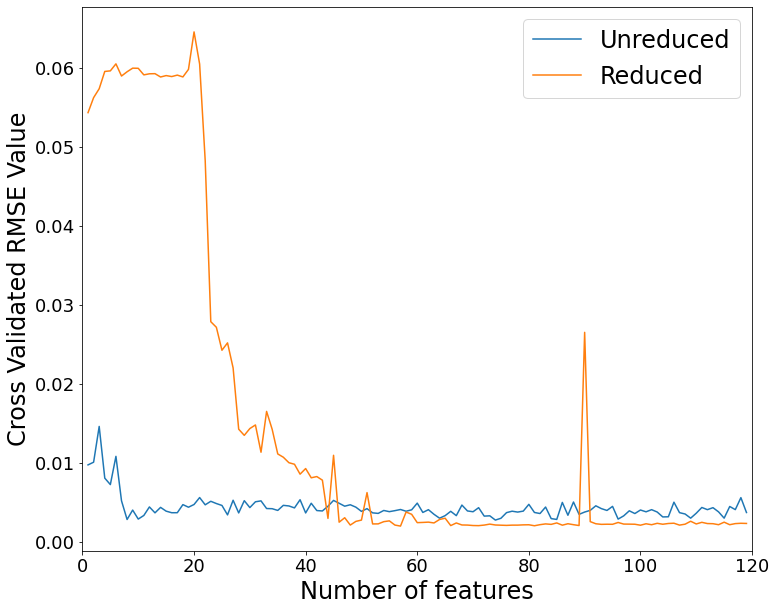

In [70]:
plt.figure(figsize=(12,10))

plt.plot(renge, urscorecv, label = 'Unreduced')
plt.plot(renge, rscorecv, label='Reduced')

plt.xlabel('Number of features', fontsize=24)
plt.ylabel("Cross Validated RMSE Value", fontsize=24)

plt.xlim([0, 120])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize=24)

print(min(urscorecv), min(rscorecv))
print(max(urscorecv), max(rscorecv))



0.050520926435320426 0.041639762349773374
0.10717687149667864 0.23973475008228873


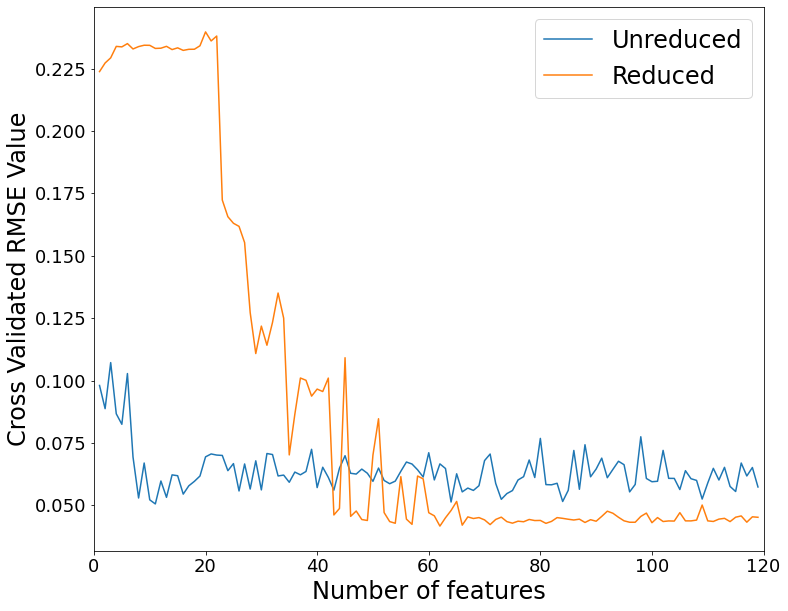

In [71]:
plt.figure(figsize=(12,10))

plt.plot(renge, urscorel2, label = 'Unreduced')
plt.plot(renge, rscorel2, label='Reduced')

plt.xlabel('Number of features', fontsize=24)
plt.ylabel("Cross Validated RMSE Value", fontsize=24)

plt.xlim([0, 120])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize=24)

print(min(urscorel2), min(rscorel2))
print(max(urscorel2), max(rscorel2))